In [100]:
import heapq
import random

import folium
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely.geometry import MultiLineString
from tqdm.notebook import tqdm

In [101]:
# main route functions

def find_candidate_routes(
    graph,
    *,
    min_gradient,
    min_length,
    max_length,
    max_depth,
    early_termination_gradient_factor,
    min_starting_node_grade,
    max_flat_section_length,
    min_section_gradient,
    max_possible_edge_gradient,
    max_candidate_routes,
):
    candidate_routes = []
    
    # preprocess edge data into a flat dictionary (for faster lookup)
    # exclude edges with grade absurdly high (indicating bad data)
    edge_data_dict = {
        (u, v): data
        for u, v, data in graph.edges(data=True)
        if data.get('grade', 0) <= 0.4
    }

    # calculate termination gradient
    termination_gradient = min_gradient * early_termination_gradient_factor
    
    # identify starting nodes connected to steep(ish) edges
    starting_nodes = set()
    for (u, v), data in edge_data_dict.items():
        edge_gradient = data.get('grade', 0)
        if edge_gradient >= min_starting_node_grade:
            starting_nodes.add(u)

    print(f"{len(starting_nodes)} starting nodes ({graph.number_of_nodes()} total)")

    # priority queue to prioritize paths with longer lengths
    queue = []
    for start_node in starting_nodes:
        # (negative length, current_node, path, length, elevation_gain, flat_section_length)
        heapq.heappush(queue, (-0, start_node, [start_node], 0, 0, 0))
    
    while queue:
        neg_length, current_node, path, length, elevation_gain, flat_section_length = heapq.heappop(queue)
        current_depth = len(path)

        if current_depth > max_depth or length > max_length:
            continue
        
        for neighbor in graph.neighbors(current_node):
            if neighbor in path:
                continue

            # try both (u, v) and (v, u) in case of undirected graph
            edge_data = edge_data_dict.get((current_node, neighbor)) or edge_data_dict.get((neighbor, current_node))
            if edge_data is None:
                continue
            
            edge_length = edge_data.get('length', 0)
            edge_gradient = edge_data.get('grade', 0)

            elevation_diff = edge_length * edge_gradient  # calculated elevation gain (can be negative)

            new_length = length + edge_length
            new_elevation_gain = elevation_gain + elevation_diff
            new_avg_gradient = new_elevation_gain / new_length if new_length > 0 else 0

            # update cumulative flat/downhill section length
            new_flat_section_length = flat_section_length
            if edge_gradient < min_section_gradient:
                new_flat_section_length += edge_length

            # exceeds allowed length of flat/downhill sections
            if new_flat_section_length > max_flat_section_length:
                continue

            # Early termination based on cumulative gradient
            if new_avg_gradient < termination_gradient:
                continue
            
            # prune paths that cannot meet the minimum average gradient
            # estimate the maximum possible elevation gain achievable
            remaining_edges = max_depth - current_depth
            average_edge_length = new_length / current_depth if current_depth > 0 else edge_length
            remaining_possible_gain = remaining_edges * average_edge_length * max_possible_edge_gradient
            max_possible_elevation_gain = new_elevation_gain + remaining_possible_gain
            max_possible_avg_gradient = max_possible_elevation_gain / new_length if new_length > 0 else 0
            if max_possible_avg_gradient < min_gradient:
                continue  
            
            new_path = path + [neighbor]

            # add path to candidate_routes if it meets constraints
            if new_length >= min_length and new_avg_gradient >= min_gradient:
                candidate_routes.append((new_path, new_length, new_avg_gradient))
                if len(candidate_routes) >= max_candidate_routes:
                    return candidate_routes

            # continue expanding the path, prioritizing by negative length to maximize route length
            heapq.heappush(queue, (
                -(new_length),
                neighbor,
                new_path,
                new_length,
                new_elevation_gain,
                new_flat_section_length,
            ))

    return candidate_routes


def dedupe_routes(candidate_routes):
    # sort routes by length (longest first)
    candidate_routes.sort(key=lambda x: x[1], reverse=True)

    final_routes = []
    used_edges = set()

    for path, length, avg_gradient in candidate_routes:
        # check if any edge in the path has already been used
        route_edges = [(u, v) for u, v in zip(path[:-1], path[1:])]
        if any(edge in used_edges or (edge[1], edge[0]) in used_edges for edge in route_edges):
            continue  # skip this route as it overlaps with an assigned route

        # assign the route and mark its edges as used
        final_routes.append((path, length, avg_gradient))
        for edge in route_edges:
            used_edges.add(edge)
            used_edges.add((edge[1], edge[0]))  # add both directions if the graph is undirected

    return final_routes


def get_route_name(path, graph):
    street_names = []
    last_name = None

    for u, v in zip(path[:-1], path[1:]):
        edge_data = graph.get_edge_data(u, v, 0)
        names = edge_data.get('name', None)

        if names:
            if isinstance(names, list):
                names = [name.strip() for name in names if name.strip()]
                street_name = ', '.join(names)
            else:
                street_name = names.strip()

            if street_name and street_name != last_name:
                street_names.append(street_name)
                last_name = street_name

    return ' - '.join(street_names) if street_names else 'Unknown Streets'

In [102]:
# other small misc helper fns

def miles_to_meters(miles):
    return miles * 1609.34

In [103]:
# load graph from file
graph = ox.load_graphml("../data/places/asheville.graphml")

In [104]:
# constants
MIN_GRADIENT = 0.07  # Minimum average gradient (e.g., 8%)
MIN_LENGTH = miles_to_meters(2)  # Minimum length of the route (in meters)
MAX_LENGTH = miles_to_meters(5)  # Maximum length of the route (in meters)
MAX_DEPTH = 100  # Maximum depth for search (BFS)
MAX_FLAT_SECTION_LENGTH = MIN_LENGTH / 10  # Maximum length of sections below gradient threshold (in meters)
MIN_SECTION_GRADIENT = 0  # Minimum gradient for each section (e.g., 2%)
MIN_STARTING_NODE_GRADE = 0.04  # Minimum gradient for starting node edges (e.g., 5%)
MAX_POSSIBLE_EDGE_GRADIENT = 0.15  # Maximum possible edge gradient for pruning (e.g., 15%)
EARLY_TERMINATION_GRADIENT_FACTOR = 0.60  # For pruning if cumulative average gradient falls below certain level
MAX_CANDIDATE_ROUTES = 75000  # Maximum number of candidate routes to find

In [105]:
# find all candidate routes
candidate_routes = find_candidate_routes(
    graph,
    min_gradient=MIN_GRADIENT,
    min_length=MIN_LENGTH,
    max_length=MAX_LENGTH,
    max_depth=MAX_DEPTH,
    early_termination_gradient_factor=EARLY_TERMINATION_GRADIENT_FACTOR,
    min_starting_node_grade=MIN_STARTING_NODE_GRADE,
    max_flat_section_length=MAX_FLAT_SECTION_LENGTH,
    min_section_gradient=MIN_SECTION_GRADIENT,
    max_possible_edge_gradient=MAX_POSSIBLE_EDGE_GRADIENT,
    max_candidate_routes=MAX_CANDIDATE_ROUTES,
)
print(f"{len(candidate_routes)} candidate routes")

# dedupe routes (assign edges to the longest routes first)
unique_routes = dedupe_routes(candidate_routes)
print(f"{len(unique_routes)} routes after removing overlaps")

17247 starting nodes (38629 total)
2654 candidate routes
8 routes after removing overlaps


In [106]:
# print route information
for idx, (path, length, gradient) in enumerate(unique_routes):
    route_name = get_route_name(path, graph)
    print(f"{idx + 1}. length = {length:.1f} m, avg gradient = {gradient:.2%}, route name: {route_name}")

1. length = 5312.3 m, avg gradient = 7.02%, route name: Ox Creek Road - Elk Mountain Scenic Highway - Mercy Ridge Road
2. length = 4276.8 m, avg gradient = 7.00%, route name: Edwin Place - Charlotte Street - Cherokee Road - Terrace Road - Banbury Cross Street - Terrace Road - Quarry Road - Canterbury Road - Cherokee Road - Blue Briar Road - Town Mountain Road - Westhaven Drive - Sunset Summit - Patton Mountain Road
3. length = 3847.7 m, avg gradient = 7.13%, route name: North Woodfin Avenue - Senator Reynolds Road - Reynolds Heights - Senator Reynolds Road - Windsor Road - Summit Tower Circle
4. length = 3382.9 m, avg gradient = 10.23%, route name: Spivey Mountain Road
5. length = 3331.0 m, avg gradient = 7.16%, route name: Christian Creek Road - Bryant Road - Will Campbell Road
6. length = 3312.7 m, avg gradient = 7.29%, route name: Elk Mountain Scenic Highway - Elk Ridge Drive
7. length = 3244.8 m, avg gradient = 7.04%, route name: Royal Pines Drive - Laurel Road - Poplar Terrace - M

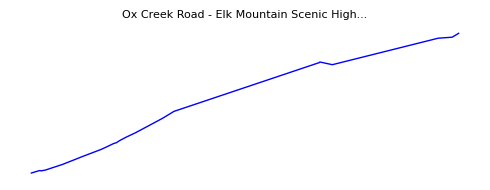

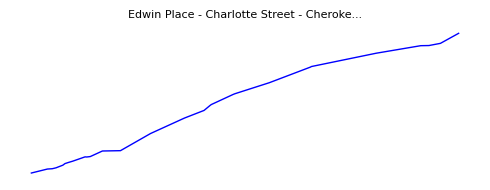

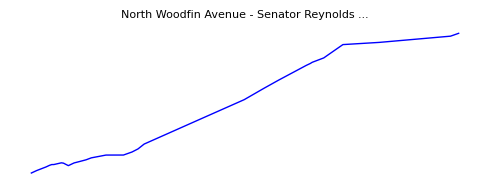

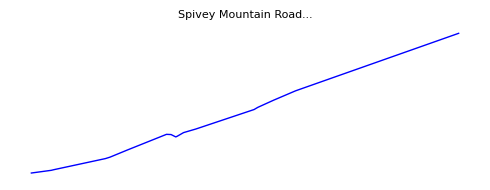

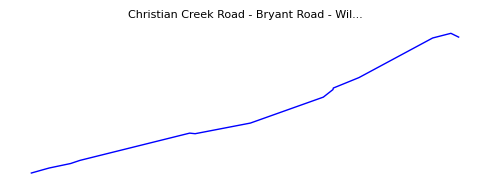

In [107]:
# visualize elevation profiles

def plot_route_elevation_profile(route, graph):
    path, length, avg_gradient = route
    route_name = get_route_name(path, graph)
    
    distances = [0]
    elevations = []
    cumulative_distance = 0
    elevations = [graph.nodes[node].get('elevation', 0) for node in path]
    
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edge_data = graph.get_edge_data(u, v, 0)
        edge_length = edge_data.get('length', 0)
        cumulative_distance += edge_length
        distances.append(cumulative_distance)

    plt.figure(figsize=(5, 2))
    plt.plot(distances, elevations, color='blue', linewidth=1)
    plt.title(f"{route_name[:40]}...", fontsize=8)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

for route in unique_routes[:5]:
    plot_route_elevation_profile(route, graph)

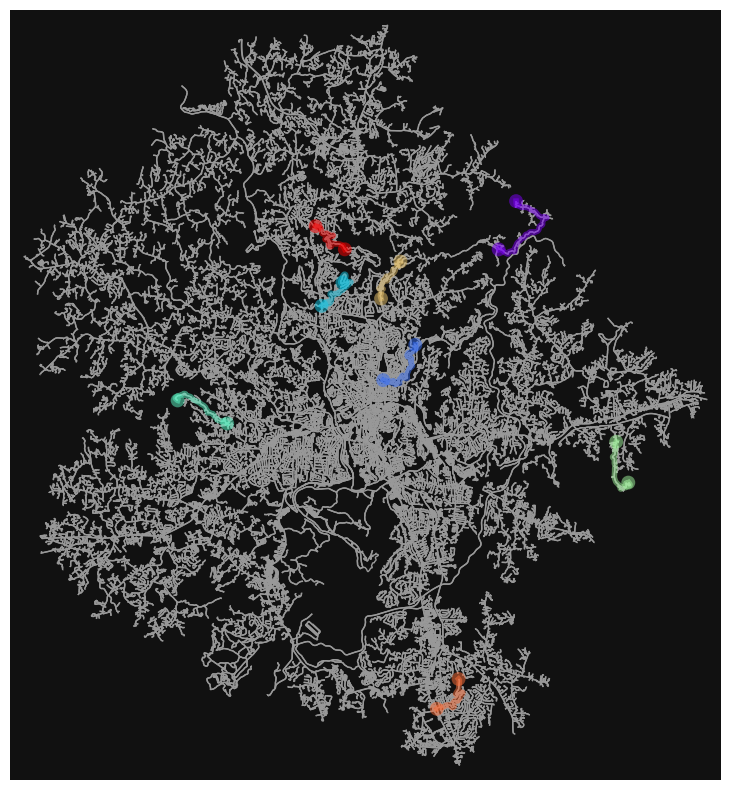

In [108]:
# visualize routes

# extract routes from unique_routes
routes = [path for path, _, _ in unique_routes]

# generate a color map for the routes
cmap = plt.get_cmap('rainbow', len(routes))
route_colors = [mcolors.rgb2hex(cmap(i)) for i in range(len(routes))]

# plot the graph with the routes
fig, ax = ox.plot_graph_routes(
    graph,
    routes,
    route_colors=route_colors,
    route_linewidth=3,
    node_size=0,
    show=False,
    close=False
)

# save and display plot
fig.set_size_inches(10, 10)
plt.savefig("../data/results/asheville-climbs.png", dpi=300)
plt.show()

In [109]:
# export results to an html w/ an interactive map

# create folium map
nodes = ox.graph_to_gdfs(graph, edges=False)
center_lat = nodes.geometry.y.mean()
center_lon = nodes.geometry.x.mean()
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=13,
    tiles='cartodbpositron'
)

# collect all route geometries to compute the bounding box
route_geometries = []

# add the routes to the map
for idx, (path, length, avg_gradient) in enumerate(unique_routes):
    # get the edges for the route
    route_edges = [(u, v, 0) for u, v in zip(path[:-1], path[1:])]
    # create a subgraph for the route
    route_graph = graph.edge_subgraph(route_edges)
    # get the geometry of the route
    route_gdf = ox.graph_to_gdfs(route_graph, nodes=False, fill_edge_geometry=True)
    # ensure the geometry is in lat/lon
    if route_gdf.crs != 'EPSG:4326':
        route_gdf = route_gdf.to_crs(epsg=4326)
    # collect geometries
    route_geometries.extend(route_gdf.geometry)
    # convert the geometry to geojson
    geojson_data = route_gdf.to_json()
    # generate a random color for the route
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    # add the route to the map
    folium.GeoJson(
        geojson_data,
        name=f"Route {idx+1}",
        style_function=lambda feature, color=color: { 'color': color, 'weight': 5, 'opacity': 0.6 },
        tooltip=folium.Tooltip(f"Route {idx+1}: Length {length:.1f} m, Avg Gradient {avg_gradient:.2%}")
    ).add_to(m)

# compute the total bounding box of all routes
all_routes_geometry = MultiLineString(route_geometries)
min_lon, min_lat, max_lon, max_lat = all_routes_geometry.bounds

# fit the map to the bounds
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# save map to an html file
m.save("../data/results/asheville-climbs.html")